<a href="https://colab.research.google.com/github/viv1dixit/DATA-VISUALISATION-ON-MNIST-DATASET/blob/main/Welcome_to_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data visualization of mnist dataset

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader , Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [10]:
class MNISTvisualizer:
  def __init__(self):
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    self.train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=self.transform
        )
    self.test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=self.transform
        )

    self.train_loader = DataLoader(self.train_dataset, batch_size=64, shuffle=True)
    self.test_loader = DataLoader(self.test_dataset, batch_size=64, shuffle=False)

  def basic_dataset_info(self):
        print("=== MNIST Dataset Information ===")
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")
        print(f"Number of classes: {len(self.train_dataset.classes)}")
        print(f"Classes: {self.train_dataset.classes}")
        print(f"Image shape: {self.train_dataset[0][0].shape}")

        train_labels = [self.train_dataset[i][1] for i in range(len(self.train_dataset))]
        unique, counts = np.unique(train_labels, return_counts=True)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.bar(unique, counts)
        plt.title('Training Data Distribution by Class')
        plt.xlabel('Digit Class')
        plt.ylabel('Number of Samples')

        plt.subplot(1, 2, 2)
        plt.pie(counts, labels=unique, autopct='%1.1f%%')
        plt.title('Training Data Distribution (Percentage)')
        plt.tight_layout()
        plt.show()

  def visualize_sample_images(self, num_samples=20):
        fig, axes = plt.subplots(10, num_samples//10, figsize=(15, 12))
        fig.suptitle('Sample Images from Each Class', fontsize=16)

        for digit in range(10):
            digit_indices = [i for i, (_, label) in enumerate(self.train_dataset) if label == digit]
            selected_indices = np.random.choice(digit_indices, num_samples//10, replace=False)

            for i, idx in enumerate(selected_indices):
                image, label = self.train_dataset[idx]
                image = image.squeeze() * 0.3081 + 0.1307

                axes[digit, i].imshow(image, cmap='gray')
                axes[digit, i].set_title(f'Class: {label}')
                axes[digit, i].axis('off')

        plt.tight_layout()
        plt.show()

  def visualize_pixel_intensity_stats(self):
        sample_size = 1000
        indices = np.random.choice(len(self.train_dataset), sample_size, replace=False)
        subset = Subset(self.train_dataset, indices)

        pixel_intensities = []
        labels = []

        for image, label in subset:
            image = image.squeeze() * 0.3081 + 0.1307
            pixel_intensities.extend(image.flatten().numpy())
            labels.extend([label] * (28 * 28))

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.hist(pixel_intensities, bins=50, alpha=0.7, color='blue')
        plt.title('Overall Pixel Intensity Distribution')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

        plt.subplot(1, 3, 2)
        df = pd.DataFrame({'intensity': pixel_intensities, 'class': labels})
        for digit in range(10):
            class_intensities = df[df['class'] == digit]['intensity']
            plt.hist(class_intensities, bins=30, alpha=0.5, label=f'Class {digit}')
        plt.title('Pixel Intensity Distribution by Class')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.legend()

        plt.subplot(1, 3, 3)
        class_data = [df[df['class'] == digit]['intensity'].values for digit in range(10)]
        plt.boxplot(class_data, labels=range(10))
        plt.title('Pixel Intensity Box Plot by Class')
        plt.xlabel('Digit Class')
        plt.ylabel('Pixel Intensity')

        plt.tight_layout()
        plt.show()

  def visualize_average_images(self):
        class_sums = {i: torch.zeros(28, 28) for i in range(10)}
        class_counts = {i: 0 for i in range(10)}

        for image, label in self.train_dataset:
            image = image.squeeze() * 0.3081 + 0.1307
            class_sums[label] += image
            class_counts[label] += 1

        class_averages = {i: class_sums[i] / class_counts[i] for i in range(10)}

        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        fig.suptitle('Average Images for Each Digit Class', fontsize=16)

        for i in range(10):
            row, col = i // 5, i % 5
            axes[row, col].imshow(class_averages[i], cmap='gray')
            axes[row, col].set_title(f'Average Digit {i}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

  def create_simple_cnn(self):
        class SimpleCNN(nn.Module):
            def __init__(self):
                super(SimpleCNN, self).__init__()
                self.conv1 = nn.Conv2d(1, 32, 3, 1)
                self.conv2 = nn.Conv2d(32, 64, 3, 1)
                self.dropout1 = nn.Dropout(0.25)
                self.dropout2 = nn.Dropout(0.5)
                self.fc1 = nn.Linear(9216, 128)
                self.fc2 = nn.Linear(128, 10)

            def forward(self, x):
                x = self.conv1(x)
                x = F.relu(x)
                x = self.conv2(x)
                x = F.relu(x)
                x = F.max_pool2d(x, 2)
                x = self.dropout1(x)
                x = torch.flatten(x, 1)
                features = self.fc1(x)
                x = F.relu(features)
                x = self.dropout2(x)
                x = self.fc2(x)
                return x, features

        return SimpleCNN().to(device)

  def train_model_and_extract_features(self, epochs=5):
        model = self.create_simple_cnn()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        print("Training model...")
        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch_idx, (data, target) in enumerate(self.train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output, _ = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

                if batch_idx % 300 == 0:
                    print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

            print(f'Epoch {epoch+1} completed. Average Loss: {total_loss/len(self.train_loader):.4f}')

        return model

  def visualize_feature_maps(self, model, num_samples=4):
        model.eval()

        data_iter = iter(self.test_loader)
        images, labels = next(data_iter)
        images = images[:num_samples].to(device)

        with torch.no_grad():
            conv1_output = model.conv1(images)
            conv1_output = F.relu(conv1_output)

        fig, axes = plt.subplots(num_samples, 9, figsize=(18, 8))
        fig.suptitle('Feature Maps from First Convolutional Layer', fontsize=16)

        for i in range(num_samples):
            axes[i, 0].imshow(images[i].cpu().squeeze() * 0.3081 + 0.1307, cmap='gray')
            axes[i, 0].set_title(f'Original\nLabel: {labels[i]}')
            axes[i, 0].axis('off')

            for j in range(8):
                axes[i, j+1].imshow(conv1_output[i, j].cpu(), cmap='viridis')
                axes[i, j+1].set_title(f'Feature {j+1}')
                axes[i, j+1].axis('off')

        plt.tight_layout()
        plt.show()

  def visualize_learned_features_tsne(self, model, num_samples=1000):
        model.eval()

        features = []
        labels = []

        with torch.no_grad():
            for i, (data, target) in enumerate(self.test_loader):
                if len(features) >= num_samples:
                    break

                data = data.to(device)
                _, feature = model(data)
                features.extend(feature.cpu().numpy())
                labels.extend(target.numpy())

        features = np.array(features[:num_samples])
        labels = np.array(labels[:num_samples])

        print("Computing t-SNE embedding...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        features_2d = tsne.fit_transform(features)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('t-SNE Visualization of Learned Features')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')

        plt.subplot(1, 2, 2)
        pca = PCA(n_components=2)
        features_pca = pca.fit_transform(features)
        scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('PCA Visualization of Learned Features')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')

        plt.tight_layout()
        plt.show()

  def visualize_model_weights(self, model):
        conv1_weights = model.conv1.weight.data.cpu()

        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle('Learned Filters from First Convolutional Layer', fontsize=16)

        for i in range(32):
            row, col = i // 8, i % 8
            filter_weight = conv1_weights[i, 0]
            axes[row, col].imshow(filter_weight, cmap='gray')
            axes[row, col].set_title(f'Filter {i+1}')
            axes[row, col].axis('off')

        plt.tight_layout()
        plt.show()

  def create_confusion_matrix(self, model):
        model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in self.test_loader:
                data = data.to(device)
                output, _ = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                y_true.extend(target.numpy())
                y_pred.extend(pred.cpu().numpy().flatten())

        from sklearn.metrics import confusion_matrix, classification_report
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=range(10), yticklabels=range(10))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
        print(f"\nTest Accuracy: {accuracy:.4f}")




In [12]:
visualizer = MNISTvisualizer()

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 2.13MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.29MB/s]


=== MNIST Dataset Information ===
Training samples: 60000
Test samples: 10000
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Image shape: torch.Size([1, 28, 28])


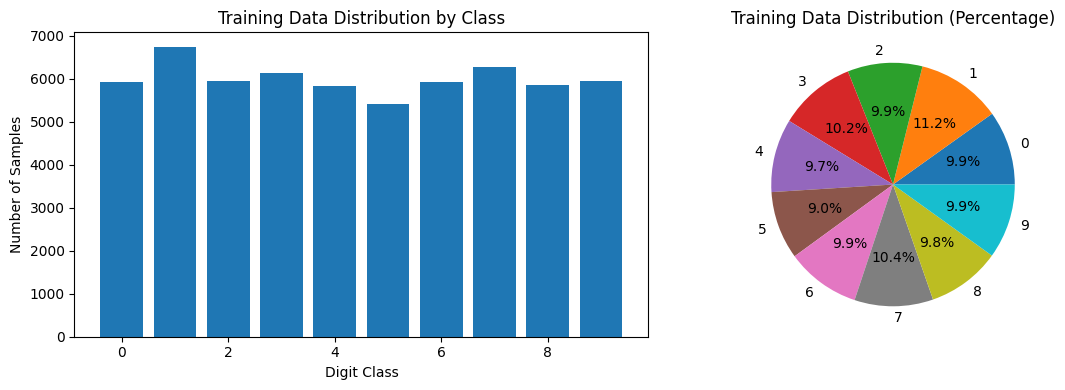

In [13]:
visualizer.basic_dataset_info()

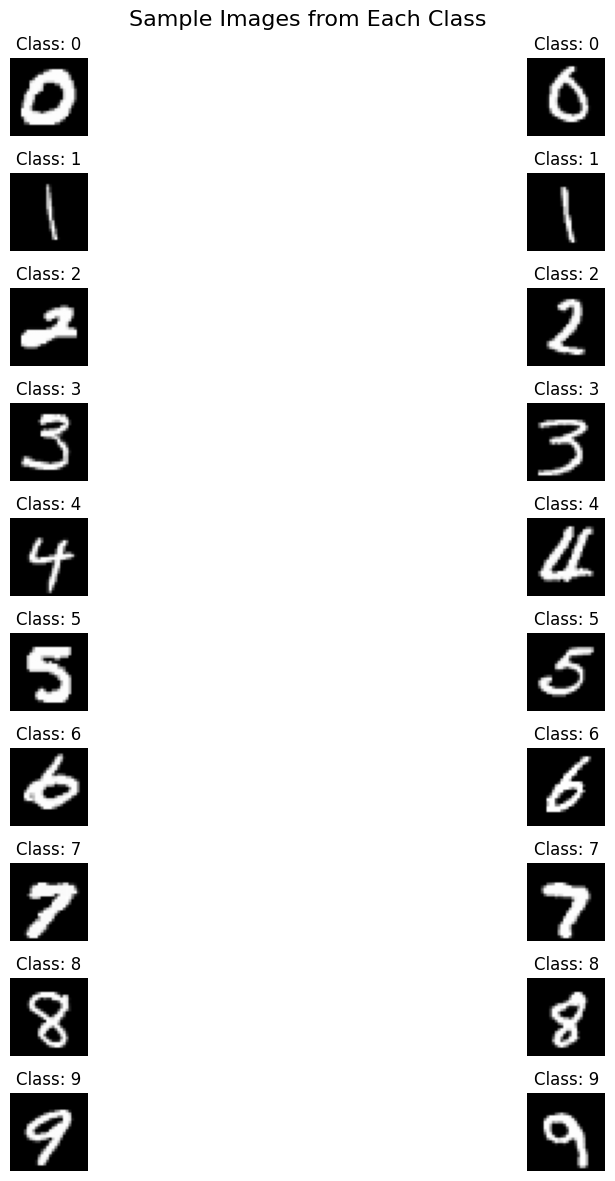

In [14]:
visualizer.visualize_sample_images()

<ipython-input-10-586622d8e9cc>:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(class_data, labels=range(10))


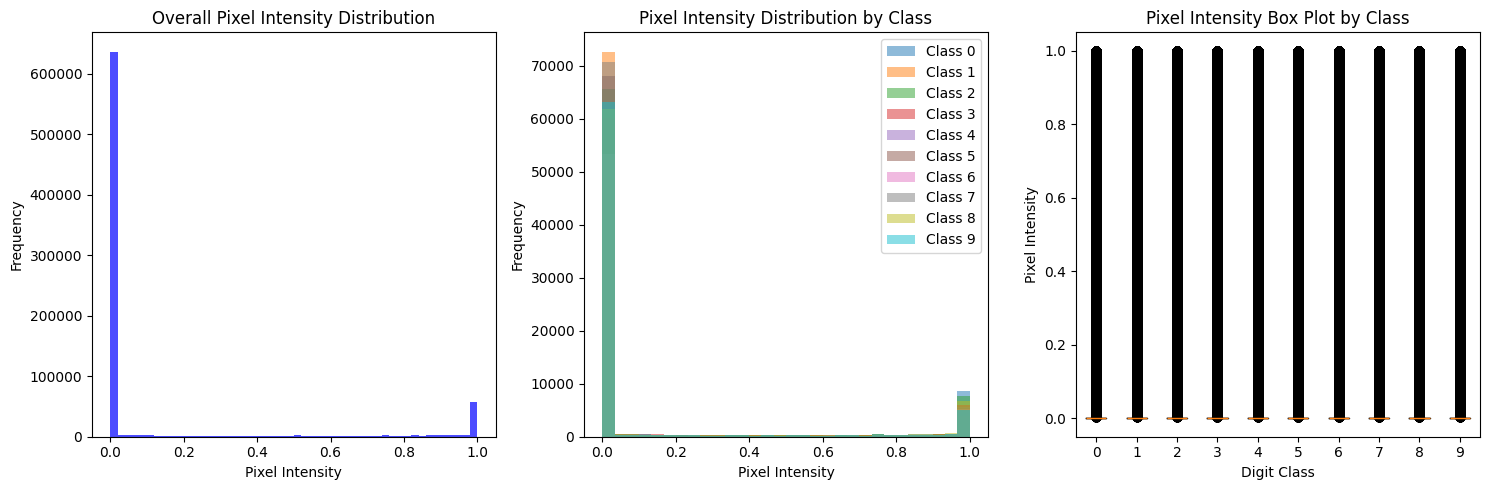

In [15]:
visualizer.visualize_pixel_intensity_stats()

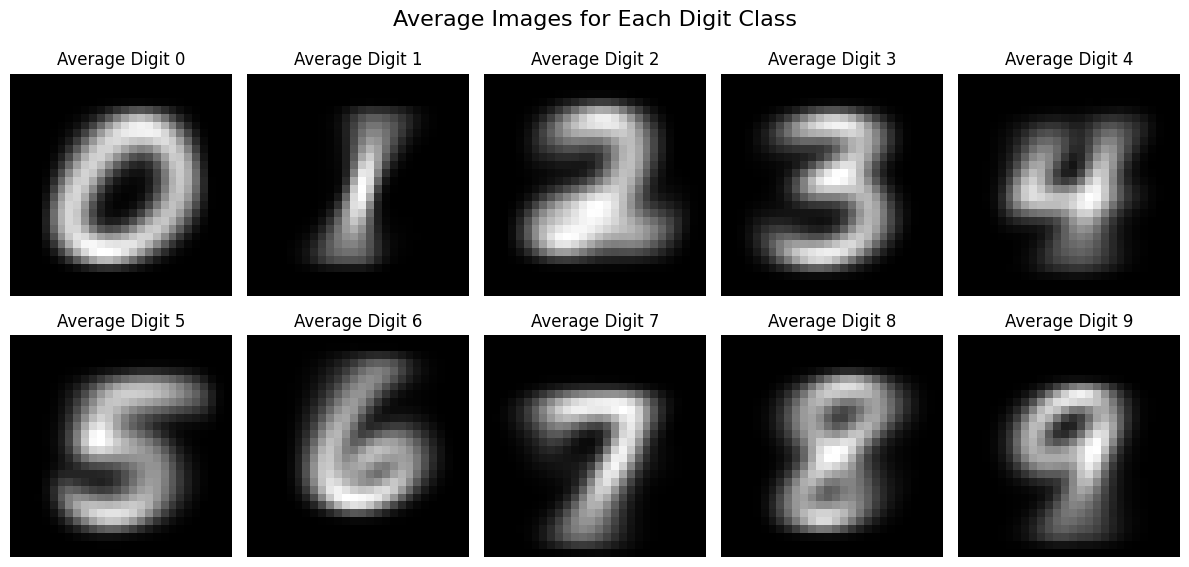

In [16]:
visualizer.visualize_average_images()

In [17]:
model = visualizer.train_model_and_extract_features(epochs=3)

Training model...
Epoch 1/3, Batch 0, Loss: 2.2953
Epoch 1/3, Batch 300, Loss: 0.0562
Epoch 1/3, Batch 600, Loss: 0.0298
Epoch 1/3, Batch 900, Loss: 0.1836
Epoch 1 completed. Average Loss: 0.2001
Epoch 2/3, Batch 0, Loss: 0.0471
Epoch 2/3, Batch 300, Loss: 0.0779
Epoch 2/3, Batch 600, Loss: 0.1075
Epoch 2/3, Batch 900, Loss: 0.0248
Epoch 2 completed. Average Loss: 0.0789
Epoch 3/3, Batch 0, Loss: 0.0180
Epoch 3/3, Batch 300, Loss: 0.0562
Epoch 3/3, Batch 600, Loss: 0.1655
Epoch 3/3, Batch 900, Loss: 0.0081
Epoch 3 completed. Average Loss: 0.0605


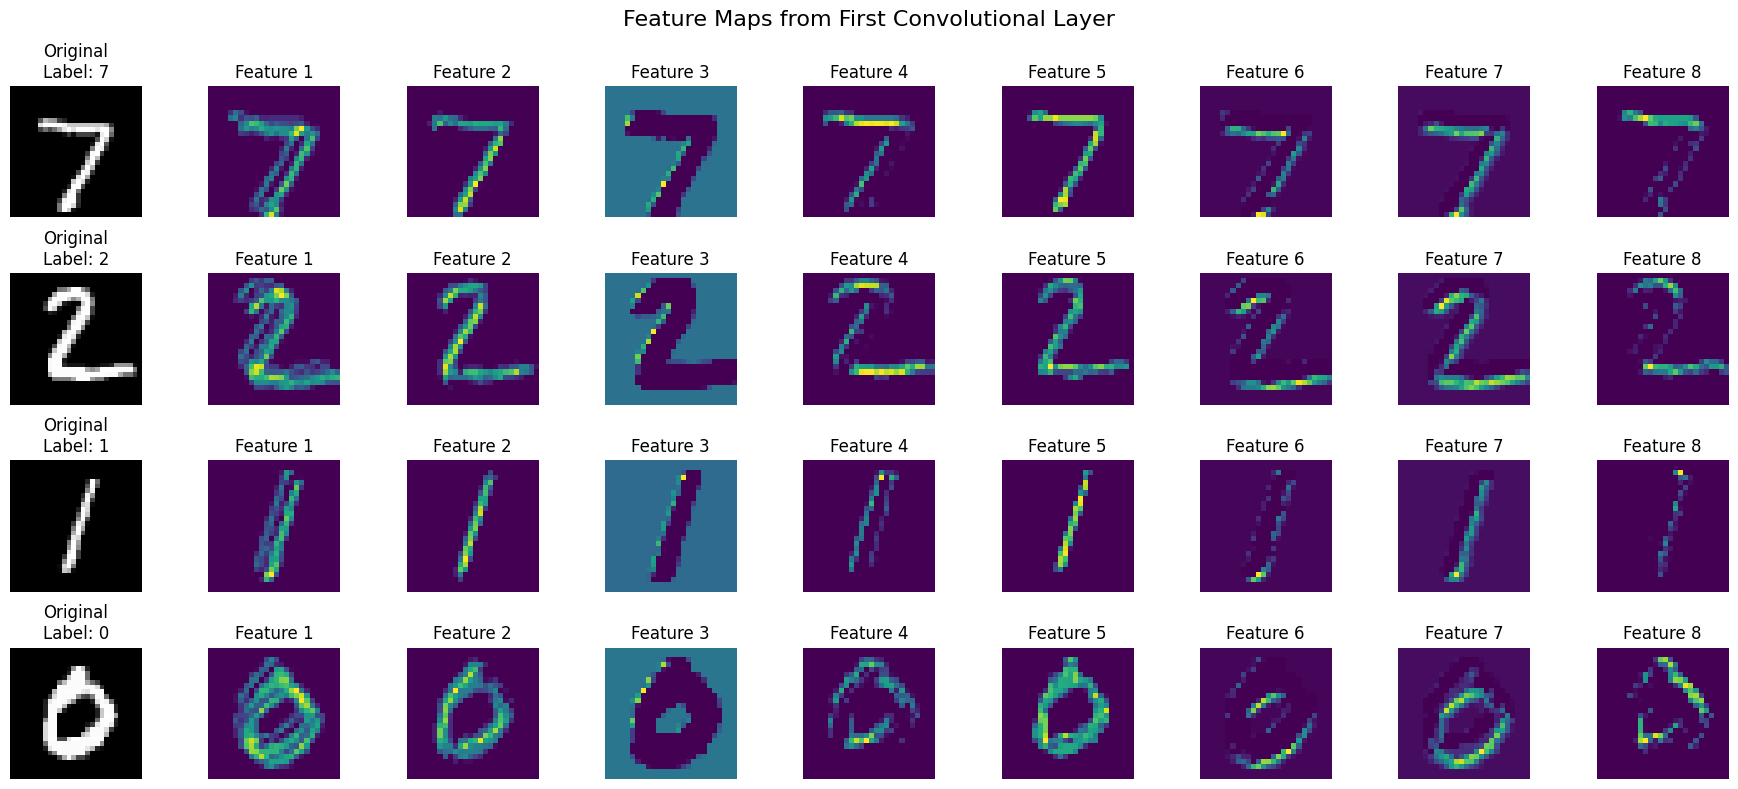

In [18]:
visualizer.visualize_feature_maps(model)

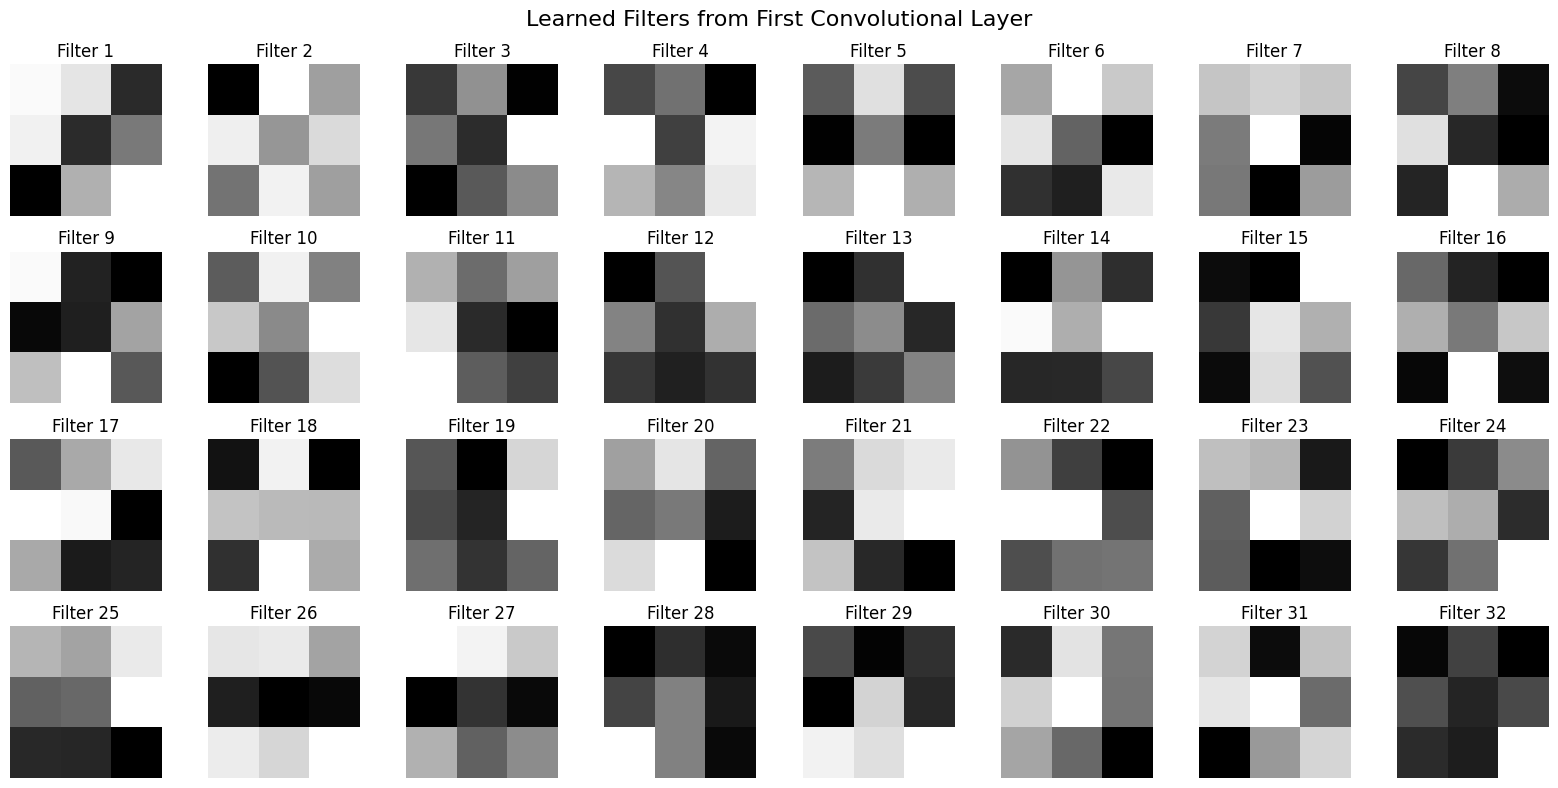

In [19]:
visualizer.visualize_model_weights(model)

Computing t-SNE embedding...


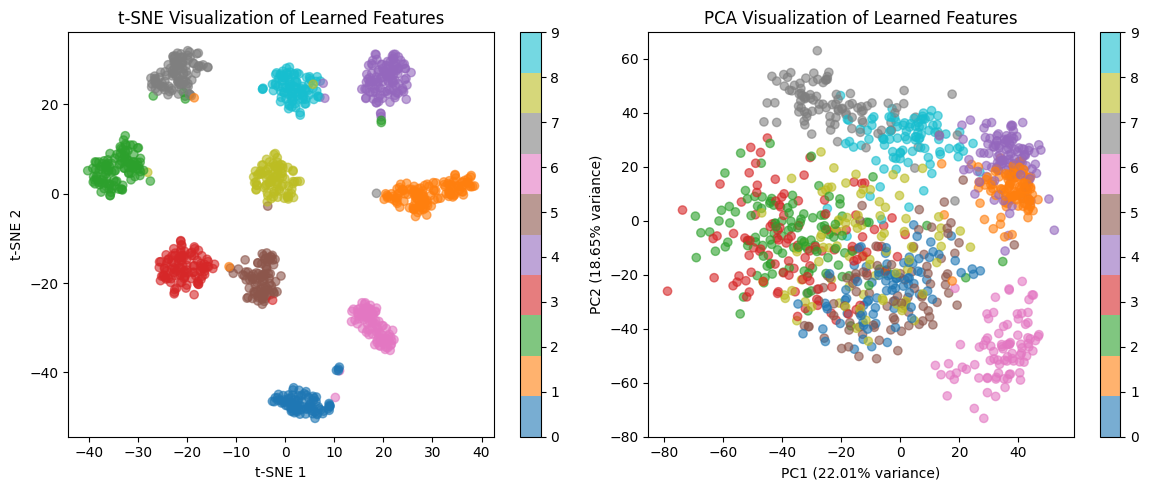

In [20]:
visualizer.visualize_learned_features_tsne(model)

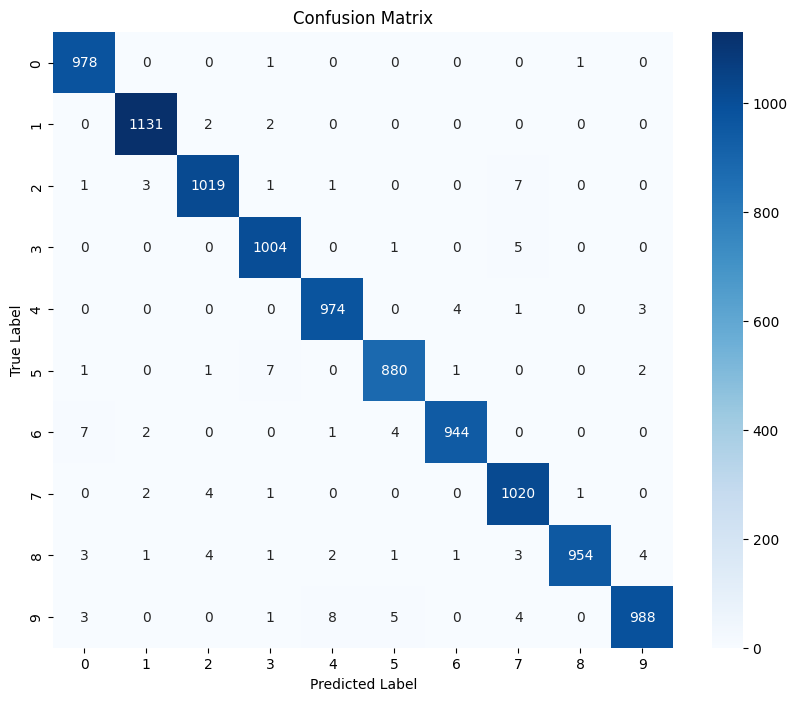


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Test Accuracy: 0.9892


In [21]:
visualizer.create_confusion_matrix(model)